# Create cropped sea ice data file
- This notebook crops the SSMI CDR data to just be around Alaska
- Note: this is on the 25x25km EASE grid
- Notebook by Alice DuVivier (NCAR)
- June 2024

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load data

In [2]:
# directory path
dir_in = '/glade/campaign/cesm/development/pcwg/ssmi/CDR/'
file_in = 'cdr_seaice_conc_daily_sh.cdr.noleap.19790101-20221231.nc'

In [3]:
ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [4]:
# look at dataset
ds

<xarray.Dataset>
Dimensions:                (time: 16060, idim: 316, jdim: 332)
Coordinates:
  * time                   (time) float32 1.381e+05 1.381e+05 ... 1.541e+05
  * jdim                   (jdim) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * idim                   (idim) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    xgrid                  (idim) float32 dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                  (jdim) float32 dask.array<chunksize=(332,), meta=np.ndarray>
    latitude               (jdim, idim) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude              (jdim, idim) float64 dask.array<chunksize=(332, 316), meta=np.ndarray>
    cdr_seaice_conc_daily  (time, jdim, idim) float32 dask.array<chunksize=(16060, 332, 316), meta=np.ndarray>
Attributes:
    program:        /glade/u/home/landrum/SSMI/concatenate_daily_ssmi.ncl
    creation_date:  Mon Jun 26 14:19:15 MDT 2023

In [5]:
# look at variable of interest
ds.cdr_seaice_conc_daily

<xarray.DataArray 'cdr_seaice_conc_daily' (time: 16060, jdim: 332, idim: 316)>
dask.array<open_dataset-cdr_seaice_conc_daily, shape=(16060, 332, 316), dtype=float32, chunksize=(16060, 332, 316), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 1.381e+05 1.381e+05 ... 1.541e+05 1.541e+05
  * jdim     (jdim) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * idim     (idim) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
Attributes:
    units:      %
    long_name:  cdr_seaice_conc concatenated from /glade/scratch/landrum/NSID...

In [6]:
# check out the time info - find that it's not intuitive
ds.time

<xarray.DataArray 'time' (time: 16060)>
array([138061., 138062., 138063., ..., 154129., 154130., 154131.],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.381e+05 1.381e+05 ... 1.541e+05 1.541e+05

### Modify the time bound

In [7]:
# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1979', end='12/31/2022', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

(16060,)


In [8]:
# assign the time coordinate
ds['time'] = dates

In [9]:
ds.time

<xarray.DataArray 'time' (time: 16060)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31

### Subset to Winter and September only

In [11]:
# Keep September daily data, because it's the seasonal sea ice max
sept_ice = ds.where(ds.time.dt.month == 9, drop=True)
# Keep all winter daily data too
winter_ice = ds.where((ds.time.dt.month >= 7) & (ds.time.dt.month <= 9), drop=True)

In [12]:
# average over the september data
sept_ice_mean = sept_ice.mean(dim='time')
winter_ice_mean = winter_ice.mean(dim='time')

In [13]:
sept_ice_mean.load()
winter_ice_mean.load()

<xarray.Dataset>
Dimensions:                (idim: 316, jdim: 332)
Coordinates:
  * jdim                   (jdim) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * idim                   (idim) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    xgrid                  (idim) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
    ygrid                  (jdim) float32 4.338e+06 4.312e+06 ... -3.938e+06
    latitude               (jdim, idim) float64 -39.36 -39.49 ... -41.72 -41.58
    longitude              (jdim, idim) float64 -42.23 -42.05 ... 135.2 135.0
    cdr_seaice_conc_daily  (jdim, idim) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

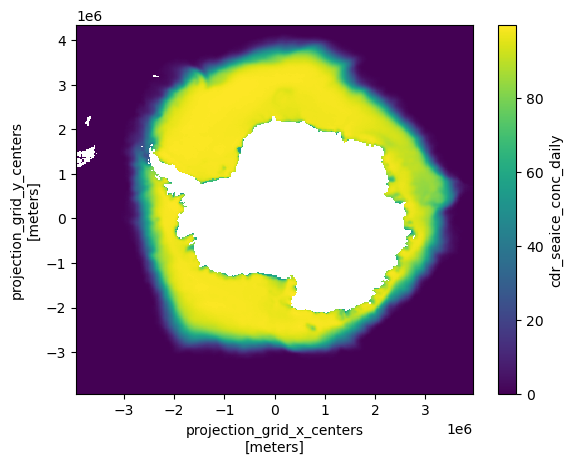

In [14]:
sept_ice_mean.cdr_seaice_conc_daily.plot()

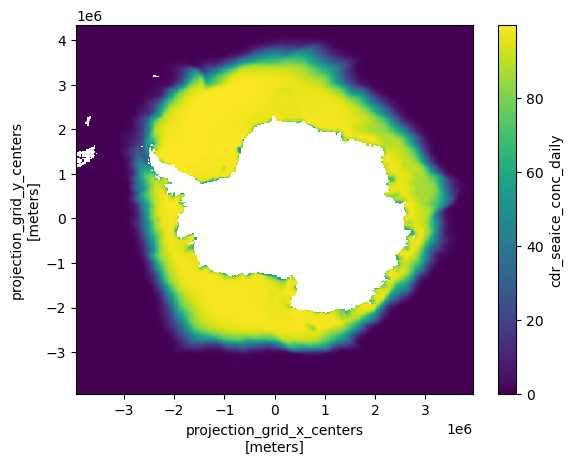

In [15]:
winter_ice_mean.cdr_seaice_conc_daily.plot()

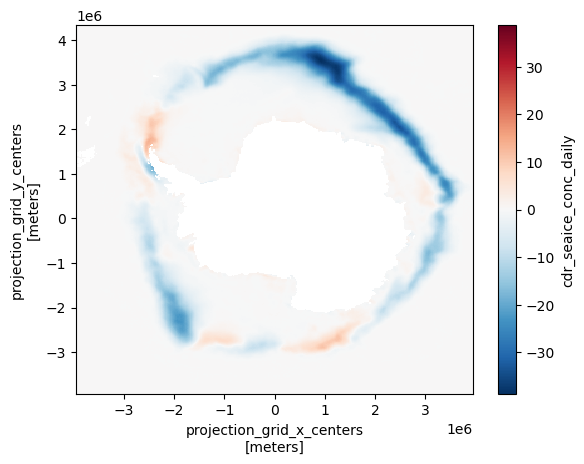

In [18]:
diff = winter_ice_mean - sept_ice_mean
diff.cdr_seaice_conc_daily.plot()

- These are very similar at the coast, differences are mainly at the ice edge
- If anything differences are positive, indicating that the winter concentration is slightly higher
- Export only the september data

## Export and Save

In [16]:
ds_sept = sept_ice_mean

# add attributes
ds_sept.attrs['processing_author'] = 'Alice DuVivier'
ds_sept.attrs['processing_date'] = datetime.now().strftime('%Y-%m-%d')
ds_sept.attrs['contents'] = f'September mean SSMI sea ice concentration averaged from daily data 1979-2022 (no leap)'

In [17]:
ds_winter = winter_ice_mean

# add attributes
ds_winter.attrs['processing_author'] = 'Alice DuVivier'
ds_winter.attrs['processing_date'] = datetime.now().strftime('%Y-%m-%d')
ds_winter.attrs['contents'] = f'Winter (JAS) mean SSMI sea ice concentration averaged from daily data 1979-2022 (no leap)'

### September

In [ ]:
ds_out = ds_sept

In [ ]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

In [ ]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")

In [ ]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'
file_out = 'cdr_seaice_conc_sept_mean.noleap.1979-2022.nc'
fout = path_out + file_out

In [ ]:
fout

In [ ]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)